## Parameter sensitivity for Carbon cycling in tropics

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params, leave_one_out, prediction_within_ci
from esem.sampler import MCMCSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

2023-06-06 15:18:28.786342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 15:18:28.962251: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 15:18:29.022897: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-06 15:18:30.841826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") ; sys.path.append("../pyth/")
from ppe_analysis.analysis import *
#from pyfunctions import *
from emulation_pyfunctions import *

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [5]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/42909/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:42963,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/42909/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load CLM-PPE LHC data

In [6]:
#dvs=['NPP','GPP','NBP']
dvs = ['GPP']
htape='h0'
yr0=1982
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [22]:
#NBP = amean(ds.NBP).mean(dim='year').compute()

In [49]:
#nbp_grid = get_map(NBP)

In [7]:
GPP = amean(ds.GPP).std(dim='year').compute()

In [8]:
gpp_grid = get_map(GPP)

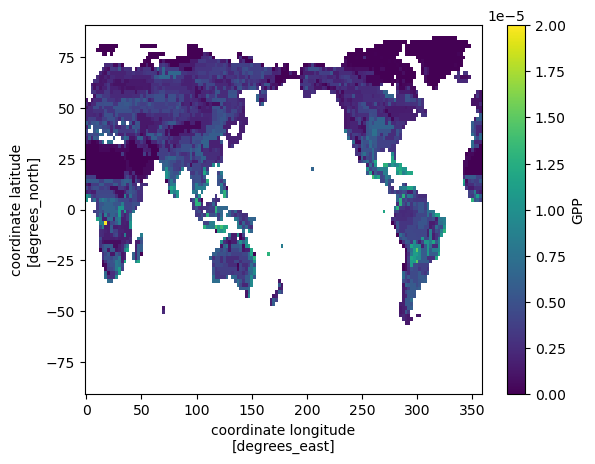

In [9]:
gpp_grid.isel(ens=0).plot()

In [10]:
f='/glade/u/home/djk2120/ppe_clean/pyth/clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg=xr.open_dataset(f)
la=sg.area*sg.landfrac
la.name='Land Area'
la.attrs={'units':sg.area.attrs['units']}

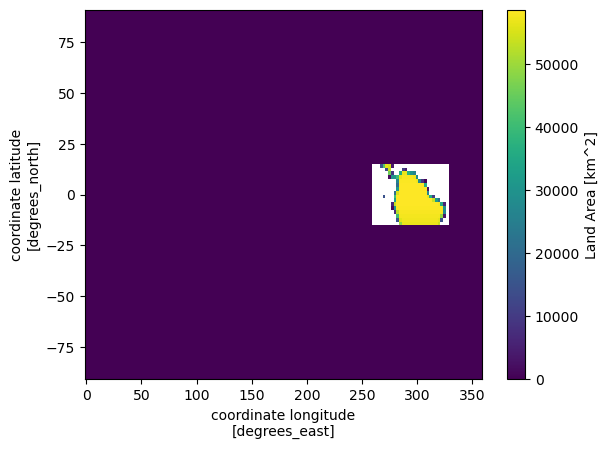

In [11]:
#set up tropical america subset
lasub_america=la.copy(deep=True)
ixlat=(sg.lat<-15)|(sg.lat>15)
ixlon=(sg.lon<260)|(sg.lon>328)
lasub_america[ixlat,:]=0
lasub_america[:,ixlon]=0
lasub_america.plot();

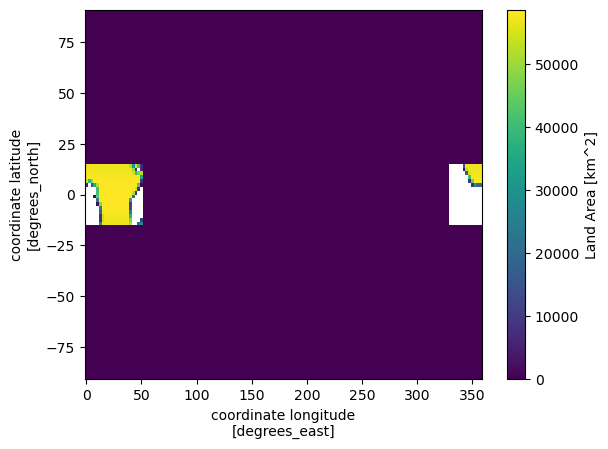

In [12]:
#set up tropical africa subset
lasub_africa=la.copy(deep=True)
ixlat=(sg.lat<-15)|(sg.lat>15)
ixlon=(sg.lon>50)&(sg.lon<330)
lasub_africa[ixlat,:]=0
lasub_africa[:,ixlon]=0
lasub_africa.plot();

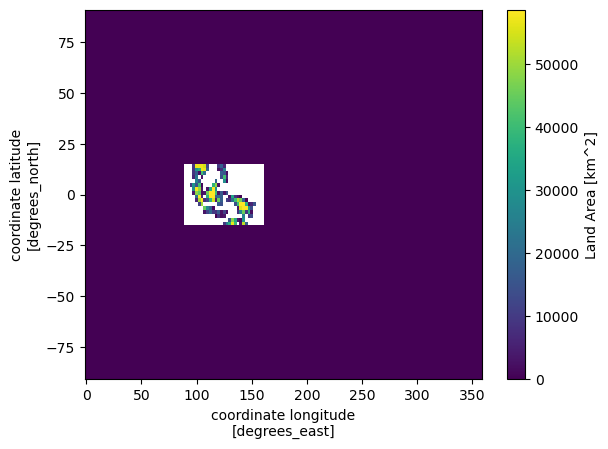

In [13]:
#set up tropical asia subset
lasub_asia=la.copy(deep=True)
ixlat=(sg.lat<-15)|(sg.lat>15)
ixlon=(sg.lon<90)|(sg.lon>160)
lasub_asia[ixlat,:]=0
lasub_asia[:,ixlon]=0
lasub_asia.plot();

In [14]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [72]:
nbp_america=1e-9*(lasub_america*nbp_grid).sum(dim=['lat','lon']).compute()
nbp_africa=1e-9*(lasub_africa*nbp_grid).sum(dim=['lat','lon']).compute()
nbp_asia=1e-9*(lasub_asia*nbp_grid).sum(dim=['lat','lon']).compute()

In [15]:
gpp_america=1e-9*(lasub_america*gpp_grid).sum(dim=['lat','lon']).compute()
gpp_africa=1e-9*(lasub_africa*gpp_grid).sum(dim=['lat','lon']).compute()
gpp_asia=1e-9*(lasub_asia*gpp_grid).sum(dim=['lat','lon']).compute()

### Train Emulator for region

In [21]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32

In [22]:
df_regions = pd.DataFrame({'america':gpp_america,'africa':gpp_africa,'asia':gpp_asia})

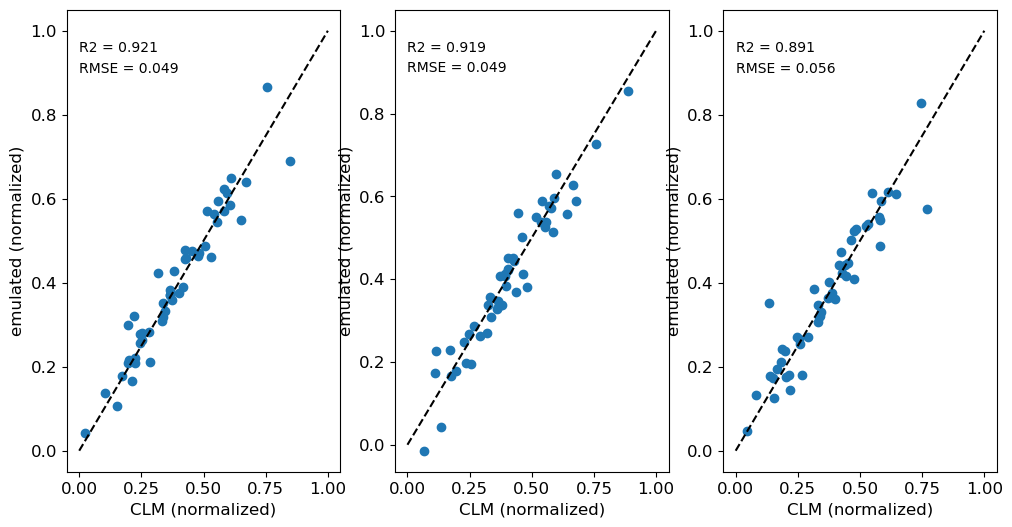

In [23]:
plt.figure(figsize=[12,6])
plt.rcParams.update({'font.size': 12})

emulator_dict = {}

for r in range(np.shape(df_regions)[1]):
    var = normalize(df_regions.iloc[:,r])
    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y[:n_test], Y[n_test:]

    # define emulator model and train
    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()
    
    emulator_dict[r] = emulator

    # Predict test points with emulator and plot
    y_pred, y_pred_var = emulator.predict(X_test.values)

    rms = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)

    ax = plt.subplot(1,3,r+1)
    ax.scatter(y_test,y_pred)
    ax.text(0,0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
    ax.text(0,0.90,'RMSE = '+str(np.round(rms,3)),fontsize=10)
    ax.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
    ax.set_xlabel('CLM (normalized)')
    ax.set_ylabel('emulated (normalized)')

### FAST analysis

In [24]:
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

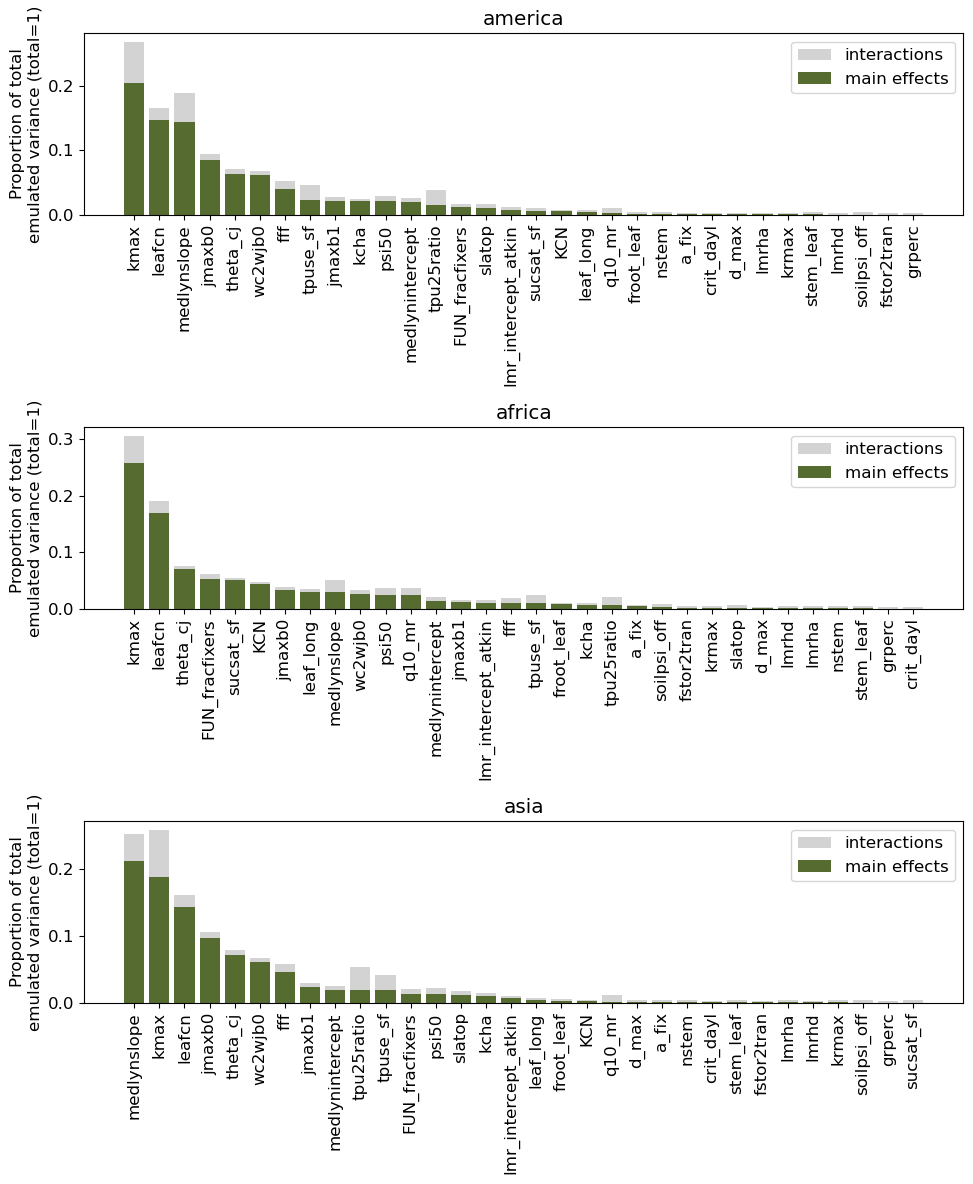

In [31]:
plt.figure(num=None, figsize=(10, 12), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

for r in range(3):
    sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
    Y, _ = emulator_dict[r].predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    sens = pd.DataFrame.from_dict(FAST)
    sens.index = sens.names
    df_sens = sens.sort_values(by=['S1'],ascending=False)
    
    if r ==0:
        FAST_sens = pd.DataFrame.from_dict(FAST['ST'])
    else:
        FAST_sens[r] = FAST['ST']

    ax = plt.subplot(3,1,r+1)
    ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
    ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.legend(loc='upper right')
    plt.ylabel('Proportion of total\nemulated variance (total=1)')
    plt.title(df_regions.columns[r])
    plt.tight_layout()
plt.savefig('./working_dir/figs/FAST_sensitivity_tropical_carbon_GPPstdev.png',dpi=200)#

In [43]:
params = ppe_params.columns
var_names = ['America','Africa','Asia']
FAST_sens.index = params
FAST_sens.columns = var_names


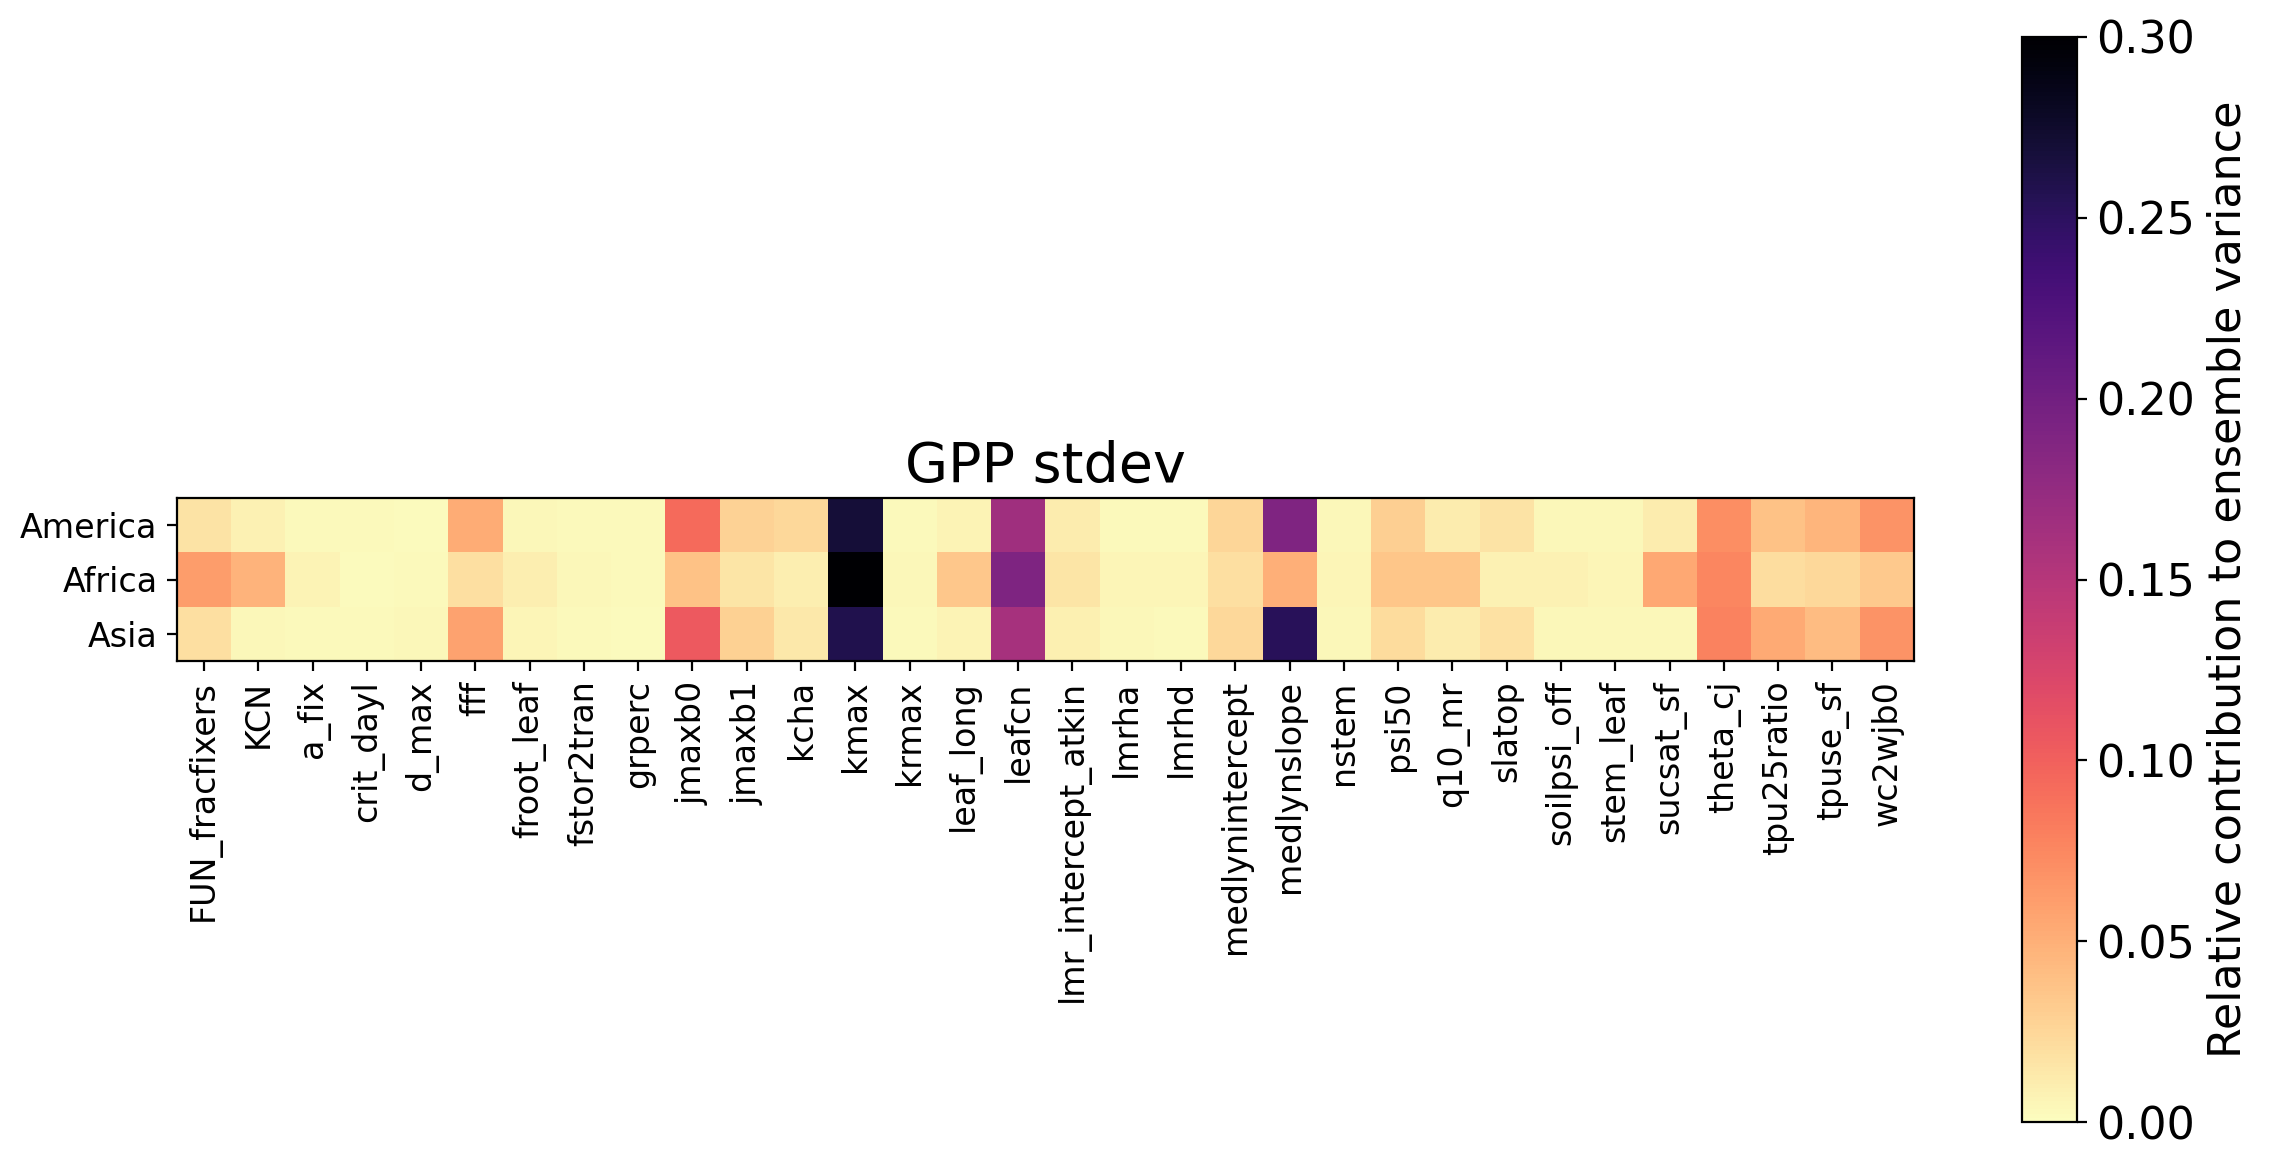

In [44]:
# Heat map
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
im = ax.imshow(FAST_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.3)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative contribution to ensemble variance",fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.title('GPP stdev',fontsize=20)
plt.tight_layout()